In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [22]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [23]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [24]:
SEED = 1


cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [25]:
dropout_value = 0.10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 4
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6
        #self.pool2 = nn.MaxPool2d(2, 2)
        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        ) #output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
                   ) # output_size =

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        #x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [26]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 32, 24, 24]           4,608
              ReLU-5           [-1, 32, 24, 24]               0
       BatchNorm2d-6           [-1, 32, 24, 24]              64
           Dropout-7           [-1, 32, 24, 24]               0
         MaxPool2d-8           [-1, 32, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           4,608
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
          Dropout-12           [-1, 16, 10, 10]               0
           Conv2d-13             [-1, 16, 8, 8]           2,304
             ReLU-14             [-1, 

In [27]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [28]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.039770279079675674 Batch_id=937 Accuracy=95.12: 100%|██████████| 938/938 [00:53<00:00, 17.42it/s]



Test set: Average loss: 0.0430, Accuracy: 9856/10000 (98.56%)

EPOCH: 1


Loss=0.024695295840501785 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:53<00:00, 17.55it/s] 



Test set: Average loss: 0.0343, Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.0292084738612175 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:53<00:00, 17.52it/s]   



Test set: Average loss: 0.0304, Accuracy: 9894/10000 (98.94%)

EPOCH: 3


Loss=0.03703087195754051 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [01:01<00:00, 15.29it/s]  



Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 4


Loss=0.002314083045348525 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:56<00:00, 16.51it/s] 



Test set: Average loss: 0.0219, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.01629195176064968 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:59<00:00, 15.76it/s]  



Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 6


Loss=0.0021127827931195498 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:58<00:00, 15.99it/s]



Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.2742671072483063 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:58<00:00, 16.14it/s]   



Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Loss=0.008908207528293133 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:56<00:00, 16.55it/s] 



Test set: Average loss: 0.0202, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.0318770669400692 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:58<00:00, 15.96it/s]   



Test set: Average loss: 0.0220, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.0766654685139656 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:59<00:00, 15.85it/s]   



Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.06497964262962341 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:58<00:00, 16.10it/s]  



Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.0031381193548440933 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:57<00:00, 16.21it/s]



Test set: Average loss: 0.0165, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.0023845420219004154 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:57<00:00, 16.32it/s] 



Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.0741342306137085 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:57<00:00, 16.37it/s]   



Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.01113898679614067 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:54<00:00, 17.35it/s]  



Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.006563953589648008 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:54<00:00, 17.36it/s]  



Test set: Average loss: 0.0157, Accuracy: 9944/10000 (99.44%)

EPOCH: 17


Loss=0.030629007145762444 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:54<00:00, 17.30it/s]  



Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.0008694843272678554 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:54<00:00, 17.31it/s] 



Test set: Average loss: 0.0185, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.00133767060469836 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:54<00:00, 17.18it/s]   



Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)



In [29]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

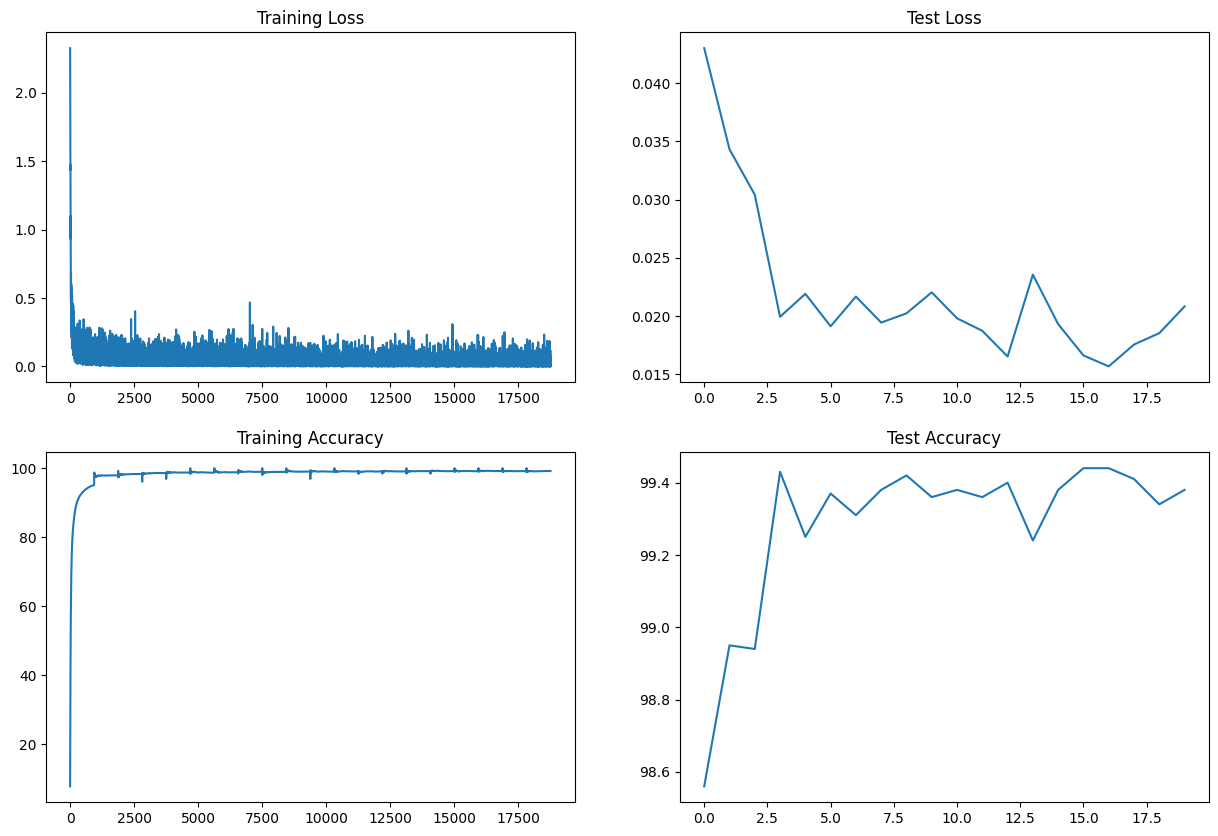

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:

1) Utilized Layers:
   - Convolution
   - 1x1 Kernel
   - 3x3 Kernel
   - Batch Normalization
   - Dropout
   - Softmax Activation
   - Learning Rate

2) Parameter Constraint:
   - Ensured model parameter count is less than 20k.

3) Total Epochs:
   - Trained the model for a total of 20 epochs.

## Results:
- Parameters: 16,196
- Best Training Accuracy: 99.19%
- Best Test Accuracy: 99.44%

## Analysis and Additional Considerations:
1) model is Underfitting
2) Learning Rate Scheduler can help in stabilizing training and test
3) Tried different location of Batch-Norm and Dropout location for batter result
